In [3]:
setwd("/projects/PPC/analysis/ppc_eqtls")

source("scripts/packages.R"  )
source("scripts/functions.R" )
source("scripts/input_data.R")
source("scripts/general_plotting_functions.R")

library(png)
library(grid)
library(ggbreak)

# Figure 1A

Warning message:
“`qplot()` was deprecated in ggplot2 3.4.0.”


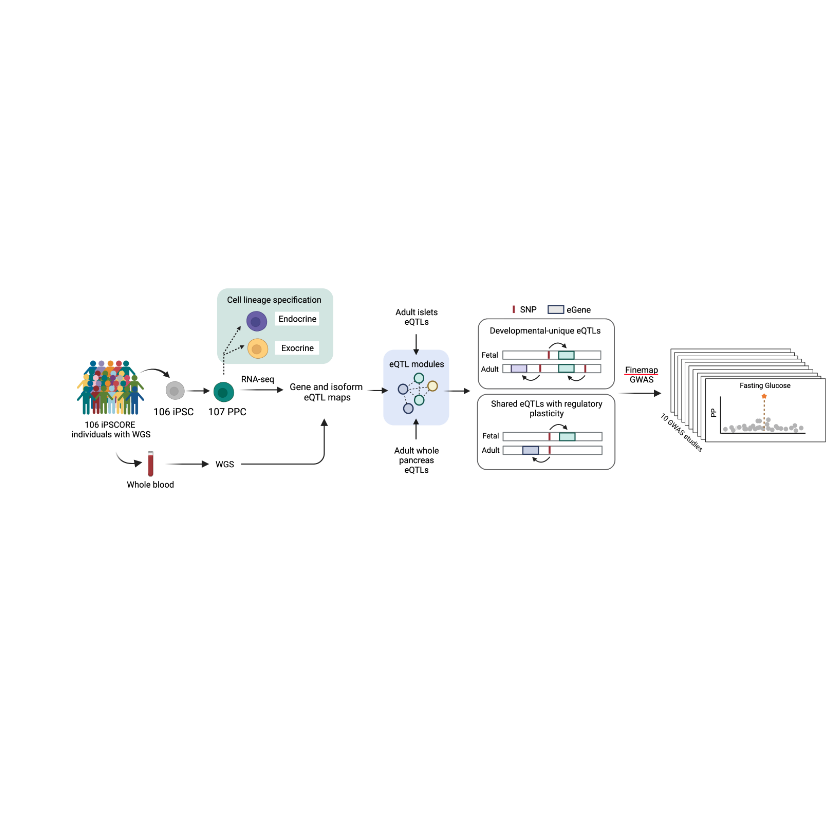

In [2]:
img <- readPNG("reviews/overview_v13.png")
g <- rasterGrob(img, interpolate=TRUE)

overview = qplot(1:10, 1:10, geom="blank") +
  annotation_custom(g, xmin=-Inf, xmax=Inf, ymin=-Inf, ymax=Inf) +
    jn_theme + theme(axis.ticks = element_blank(), axis.text = element_blank())  + 
    xlab("") + ylab("") + ylim(0,5) + theme(panel.border = element_blank()) + 
    xlim(0,5) +
    theme(plot.margin = margin(t = 5, r = 5, l = 5, b = 5))

overview

# Figure 1B

1



   udid subject_uuid wgs_uuid live_scrna_uuid cryo_scrna_pool_uuid
NA <NA>         <NA>     <NA>            <NA>                 <NA>
   cryo_scrna_pool_name live_scrna_pi_hat bulk_rna_uuid sequencing_run_uuid.1
NA                 <NA>                NA          <NA>                  <NA>
   sequencing_run_uuid.2 ipsc_clone ipsc_passage_at_monolayer pct_pdx1_nkx61
NA                  <NA>       <NA>                      <NA>             NA
   pct_pdx1 pct_nkx61 total_reads total_reads_norm
NA       NA        NA          NA               NA
   uniquely_mapped_reads_to_canonical_chromsomes pct_intergenic_bases
NA                                            NA                   NA
   pct_mrna_bases pct_duplicates mitochondrial_reads bulk_rna_pi_hat peer1
NA             NA             NA                  NA              NA    NA
   peer2 peer3 peer4 peer5 peer6 peer7 peer8 peer9 peer10 peer11 peer12 peer13
NA    NA    NA    NA    NA    NA    NA    NA    NA     NA     NA     NA     NA
   pee

Using udid as id variables

Warning message:
“Removed 1 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 1 rows containing non-finite values (`stat_density()`).”


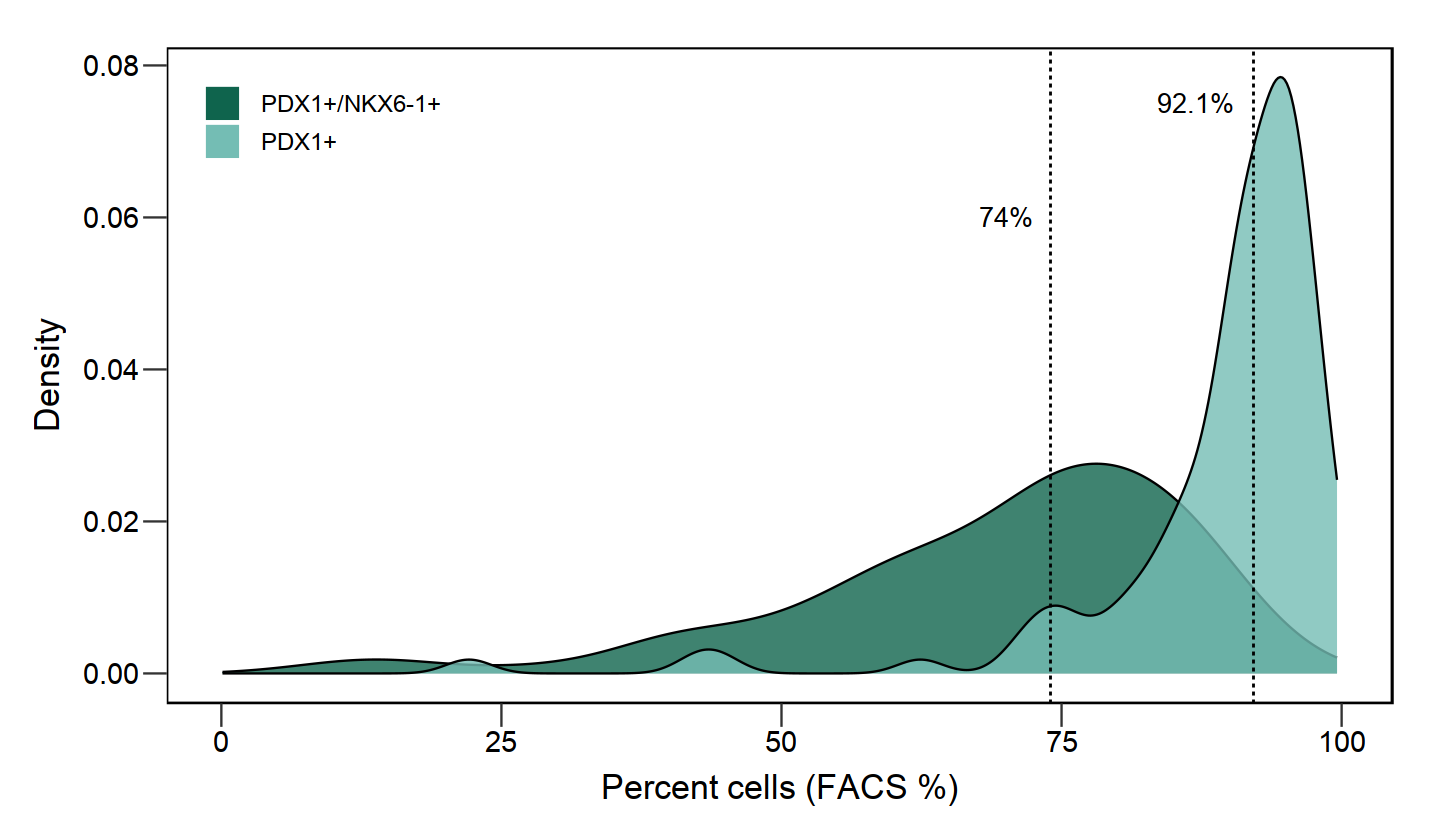

In [58]:
plot_pdx1 = function()
{
#     meta = fread("manuscript/tables/Table_SX_Sample_Info.txt", data.table = F)
    
    # 1. Read Table
    meta = fread("reviews/tables/Table_SX_Sample_Metadata.txt", data.table = F) %>%
        dplyr::rename(pct_pdx1_nkx61 = day15_pdx1_nkx6.1,
                      pct_nkx61 = day15_nkx6.1,
                      pct_pdx1 = day15_pdx1)

    # 2. Calculate cells that only express PDX
    meta$pdx_only = meta$pct_pdx1 - meta$pct_pdx1_nkx61 
    
    # 3. Calculate cells that only express NKX6-1
    meta$nkx_only = meta$pct_nkx61 - meta$pct_pdx1_nkx61
    
    # 4. Check how many samples have % cells > 100% (there are none)
    meta = meta %>% arrange(desc(pct_pdx1_nkx61))
    meta$negative = 100 - meta$pdx_only - meta$nkx_only - meta$pct_pdx1_nkx61
    
    message(nrow(meta[meta$negative < 0 & !is.na(meta$udid),]))
    print(meta[meta$negative < 0,])

    # 5. Melt
    toplot = melt(meta[,c("udid", "pct_pdx1_nkx61", "pct_pdx1", "pdx_only")])
    toplot$variable = factor(toplot$variable, levels = rev(c("pct_pdx1_nkx61", "pdx_only", "pct_pdx1")))

    options(repr.plot.height = 7, repr.plot.width = 12)
    p1 = ggplot() + jn_theme + ylab("Density") +
        geom_density(data = toplot %>% filter(variable == "pct_pdx1_nkx61"), aes(x = value, fill = variable), alpha = 0.8, color = "black", fill = "#0F644D") + 
        geom_density(data = toplot %>% filter(variable == "pct_pdx1"), aes(x = value, fill = variable), alpha = 0.8, color = "black", fill = "#74bdb4") + 
        geom_vline(xintercept = 92.1, size = 0.6, linetype = "dashed") + xlab("Percent cells (FACS %)") + 
        geom_vline(xintercept = 74, size = 0.6, linetype = "dashed") + 

        annotate("point", shape = 15, color = "#0F644D", x = 0.1, y = 0.075, size = 9) + 
        annotate("point", shape = 15, color = "#74bdb4", x = 0.1, y = 0.070, size = 9) +

        annotate("text", x = 3.5, y = 0.075, label = "PDX1+/NKX6-1+", hjust = 0, size = 5) +
        annotate("text", x = 3.5, y = 0.070, label = "PDX1+", hjust = 0, size = 5) +

        annotate("text", x = 87, y = 0.075, label = paste0(signif(median(toplot[toplot$variable == "pct_pdx1",]$value, na.rm = T), 3), "%"), size = 5.5) +
        annotate("text", x = 70, y = 0.06, label = paste0(signif(median(toplot[toplot$variable == "pct_pdx1_nkx61",]$value, na.rm = T), 3), "%"), size = 5.5) +

        theme(panel.border = element_rect(size = 0.8), 
              axis.ticks = element_line(size = 0.5),
              axis.text = element_text(size = 17), 
              plot.title = element_text(hjust = 0.5, size = 20),
              plot.margin = margin(1,1,1,1, "cm")) 

    return(p1)
}

suppressWarnings(plot_pdx1())

# Figure 1C, D

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


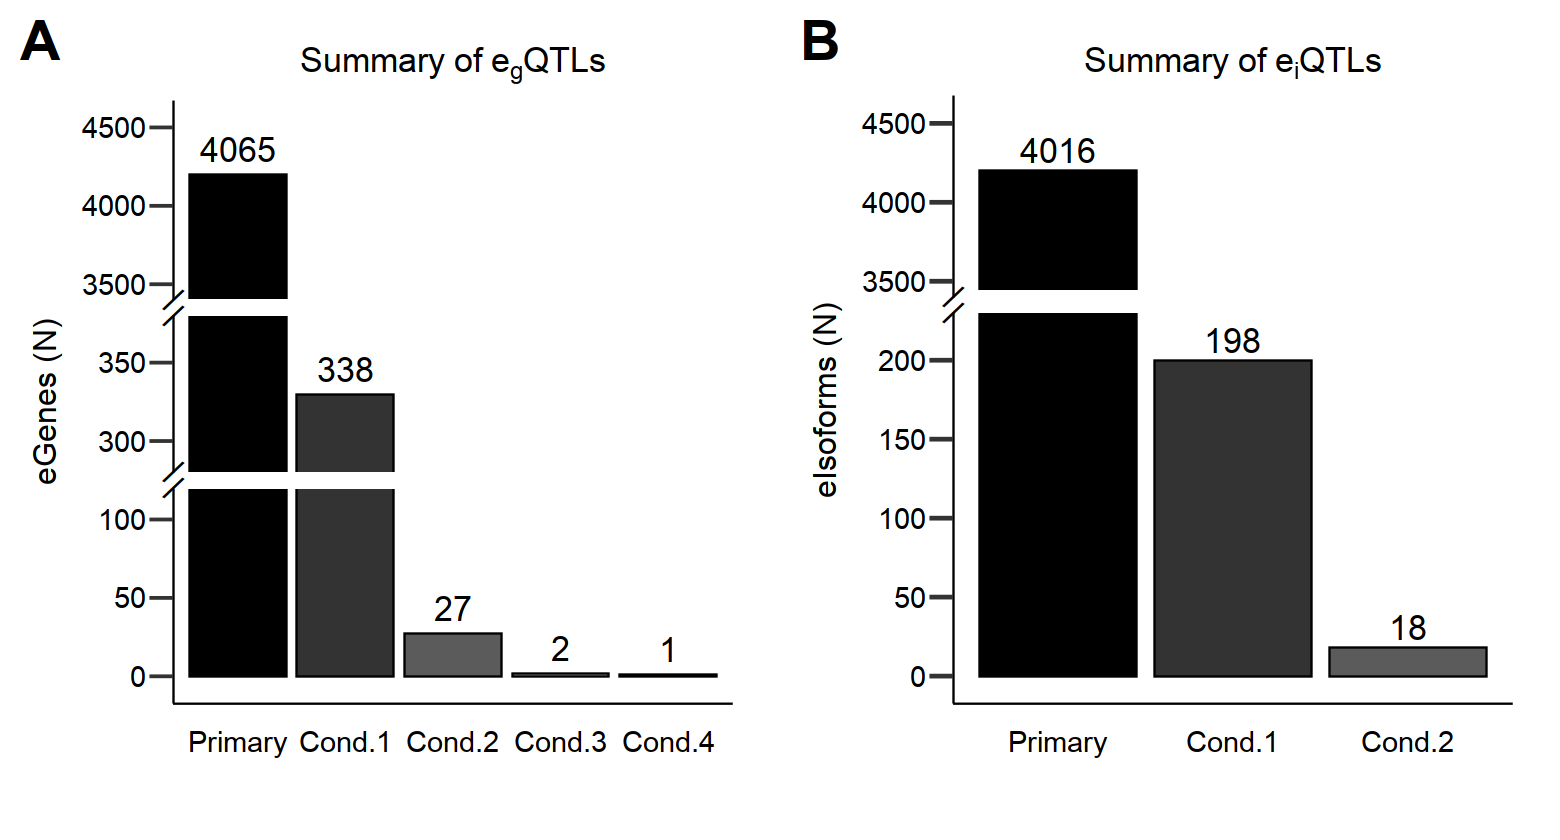

In [59]:
plot_egene = function()
{
    library(ggbreak)
    cols = c("#000000", "#333333", "#5b5b5b", "#aaaaaa", "#efefef")
    
    ppc_gene = fread("reviews/tables/Table_SX_LeadSNP.txt", data.table = F) %>% filter(eqtl_phenotype  %like% "gene" & egene == T) 
    
    toplot = data.frame(table(ppc_gene[ppc_gene$egene == T,]$discovery_order))

    toplot$label = toplot$Freq
    
    toplot[toplot$Var1 == 0,"Freq"] = 320
    toplot[toplot$Var1 == 1,"Freq"] = 180

    p = ggplot(toplot, aes(x = Var1, y = Freq, fill = Var1, label = label)) + geom_bar(stat = "identity", color = "black") + 
        jn_theme + geom_text(vjust = -0.5, size = 7) + 
        ylab("eGenes (N)") + theme(legend.position = "none") + 
        scale_fill_manual(values = cols) + xlab("") + 
        theme(panel.border = element_blank(), axis.line.x = element_line(size = 0.5)) + 
        theme(axis.ticks.x = element_blank(), axis.ticks.y = element_line(size = 0.8)) +
        annotate("rect", xmin = -Inf, xmax = Inf, ymin = 230, ymax = 240, fill = "white") +
        annotate("rect", xmin = -Inf, xmax = Inf, ymin = 120, ymax = 130, fill = "white") +
        annotate("text", x = -Inf, y = 120, label = "/", size = 8, angle = -30) + coord_cartesian(clip = "off") + 
        annotate("text", x = -Inf, y = 130, label = "/", size = 8, angle = -30) + coord_cartesian(clip = "off") + 
        annotate("text", x = -Inf, y = 230, label = "/", size = 8, angle = -30) + coord_cartesian(clip = "off") + 
        annotate("text", x = -Inf, y = 240, label = "/", size = 8, angle = -30) + coord_cartesian(clip = "off") + 
        annotate("segment", x = -Inf, xend = -Inf, y = -Inf, yend = 120, color = "black", size = 0.5) + 
        annotate("segment", x = -Inf, xend = -Inf, y = 130 , yend = 230, color = "black", size = 0.5) +
        annotate("segment", x = -Inf, xend = -Inf, y = 240 , yend = Inf, color = "black", size = 0.5) +
        scale_y_continuous(breaks = c(0, 50, 100, 150, 200, 250, 300, 350), labels = c(0, 50, 100, 300, 350, 3500, 4000, 4500), limits = c(0, 350)) + 
        scale_x_discrete(labels = c("Primary", "Cond.1", "Cond.2", "Cond.3", "Cond.4")) + 
    ggtitle(expression("Summary of e"[g]*"QTLs") ) + 
    theme(plot.title = element_text(hjust = 0.5, size = 20),
          plot.margin = margin(1,1,1,1, "cm"),
          axis.text = element_text(size = 17),
          axis.title = element_text(size = 19))
    
    return(p)
}

plot_eisoform = function()
{
    library(ggbreak)
    cols = c("#000000", "#333333", "#5b5b5b", "#aaaaaa", "#efefef")
    
    ppc_isof = fread("reviews/tables/Table_SX_LeadSNP.txt", data.table = F) %>% filter(eqtl_phenotype  %like% "isof" & egene == T)

    toplot = data.frame(table(ppc_isof[ppc_isof$egene == T,]$discovery_order))

    toplot$label = toplot$Freq

    toplot[toplot$Var1 == 0, "Freq"] = 320
    toplot[toplot$Var1 == 1, "Freq"] = 200

    p = ggplot(toplot, aes(x = Var1, y = Freq, fill = Var1, label = label)) + geom_bar(stat = "identity", color = "black") + jn_theme + 
        geom_text(vjust = -0.3, size = 7) + 
        ylab("eIsoforms (N)") + theme(legend.position = "none") +
        scale_fill_manual(values = cols) + xlab("") + 
        theme(panel.border = element_blank(), axis.line.x = element_line(size = 0.5)) + 
        theme(axis.ticks.x = element_blank(), axis.ticks.y = element_line(size = 1)) + 
        annotate("rect", xmin = -Inf, xmax = Inf, ymin = 230, ymax = 244, fill = "white") +
        annotate("text", x = -Inf, y = 230, label = "/", size = 8, angle = -30) + coord_cartesian(clip = "off") + 
        annotate("text", x = -Inf, y = 240, label = "/", size = 8, angle = -30) + coord_cartesian(clip = "off") + 
        annotate("segment", x = -Inf, xend = -Inf, y = -Inf, yend = 230, color = "black", size = 0.5) + 
        annotate("segment", x = -Inf, xend = -Inf, y = 240, yend = Inf, color = "black", size = 0.5) +
        scale_y_continuous(breaks = c(0, 50, 100, 150, 200, 250, 300, 350), labels = c(0, 50, 100, 150, 200, 3500, 4000, 4500), limits = c(0, 350)) + 
        scale_x_discrete(labels = c("Primary", "Cond.1", "Cond.2")) + 
    ggtitle(expression("Summary of e"[i]*"QTLs") ) + 
    theme(plot.title = element_text(hjust = 0.5, size = 20),
          plot.margin = margin(1,1,1,1, "cm"),
          axis.text = element_text(size = 17),
          axis.title = element_text(size = 19))

    return(p)
}

options(repr.plot.height = 7, repr.plot.width = 13)
plot_grid(plot_egene(), plot_eisoform(), nrow = 1, labels = c("A", "B"), label_size = 33)

# Plot 1E

In [63]:
load("pipeline/17.eQTLFuncEnr/summary/genomic_annot_figure_input.robj", verbose = T)
tests = test_list[["pp 0.05"]] %>% arrange(desc(estimate))
tests

Loading objects:
  test_list


annot,estimate,pval,conf.int1,conf.int2,logestimate,is_sig,p_label
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
intergenic,1.6141929,1.423877e-36,1.4970525,1.7409060,0.4788351,eGene,p = 1.42e-36
promoters,1.1682609,1.052929e-03,1.0638826,1.2829617,0.1555162,eGene,p = 0.00105
intron,1.1303323,2.467620e-04,1.0582106,1.2073820,0.1225117,eGene,p = 0.000247
RBP-BS,0.6866322,7.487665e-09,0.6024062,0.7820793,-0.3759566,eIsoform,p = 7.49e-09
splice_acceptor_long,0.6469230,1.365287e-15,0.5798938,0.7212878,-0.4355280,eIsoform,p = 1.37e-15
exon,0.6257213,5.029481e-38,0.5819583,0.6726612,-0.4688503,eIsoform,p = 5.03e-38
splice_acceptor_short,0.5877128,8.043680e-14,0.5086207,0.6782644,-0.5315169,eIsoform,p = 8.04e-14
utr,0.5665947,1.712393e-31,0.5136795,0.6246781,-0.5681110,eIsoform,p = 1.71e-31
splice_donor,0.4555756,1.455425e-10,0.3514763,0.5867784,-0.7861936,eIsoform,p = 1.46e-10


Loading objects:
  test_list


Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'expression'”
Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'expression'”


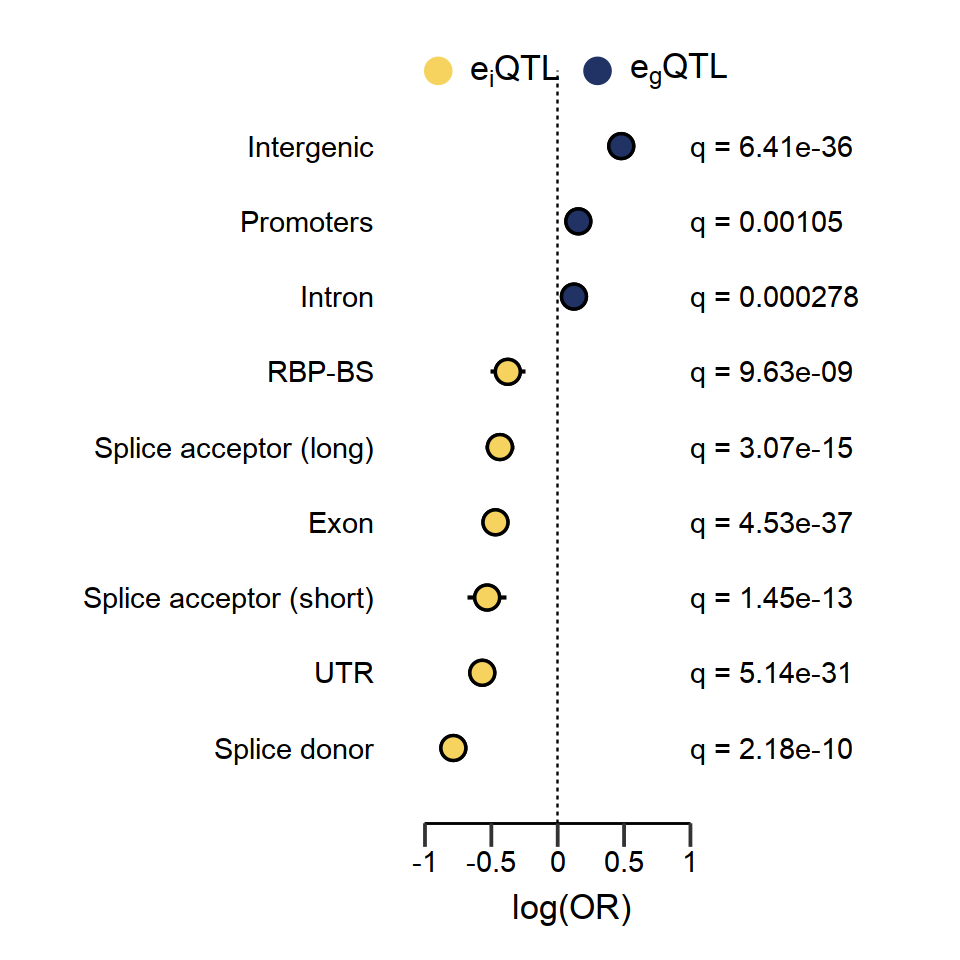

In [65]:
genomic_enr = function()
{
    # 1. Get results
    load("pipeline/17.eQTLFuncEnr/summary/genomic_annot_figure_input.robj", verbose = T)
    tests = test_list[["pp 0.05"]]
    
    # 2. Recorrect
    tests$qval = p.adjust(tests$pval, "BH")
    
    # 3. Sort by log2(OR)
    annot_order = tests %>% arrange(logestimate) %>% select(annot) %>% unlist()
    tests$annot = factor(tests$annot, levels = annot_order)
    
    # 4. p-value label
    tests$p_label = paste("q =", signif(tests$qval, 3))

    # 5. Assign coloc
    if("eGene" %in% tests$is_sig) { cols = c("#213264", "#f6d35f", "grey") } else { cols = c("#f6d35f", "grey") }

    # 6. Initialize plot
    p = ggplot() + jn_theme +
        theme(
            panel.border = element_blank(), 
            axis.ticks = element_line(size = 0.8), 
            legend.position = "top",
            plot.margin = unit(c(1,3,1,1), "lines"),
            axis.ticks.y = element_blank(),
            axis.title.x = element_text(hjust = 0.28),
        )  

    # 7. Add points
    p = p + geom_point(data = tests, aes(x = logestimate, y = annot, color = is_sig), size = 6) +
        geom_point(data = tests %>% filter(is_sig != "NS"), aes(x = logestimate, y = annot), size = 6, shape = 1, color = "black", stroke = 1.1) +
        scale_color_manual(values = cols, name = "", na.value = "#c7bcba") +
        geom_vline(xintercept = 0, linetype = "dashed") +
        ylab("") + xlab("log(OR)") +
        geom_text(data = tests[tests$is_sig != "NS",], aes(x = 1, y = annot, label = p_label), hjust = 0, size = 6, color = "black") +
        annotate("segment", x = -1, xend = 1, y = 0, yend = 0, size = 0.6) +
        scale_x_continuous(breaks = c(-1, -0.5, 0, 0.5, 1), limits = c(-1, 2.5), labels = c(-1, -0.5, 0, 0.5, 1)) 

    # 8. Add error bars
    if ("NS" %in% tests$is_sig)
    {
        p = p + geom_text(data = tests[tests$is_sig == "NS",], aes(x = 1, y = annot, label = p_label), hjust = 0, size = 8, color = "grey") 
    }

    i = 1
    for (annot in annot_order)
    {
        if (tests[tests$annot == annot,]$is_sig != "NS")
        {
            p = p + annotate("segment", y = i, yend = i, 
                         x = log(tests[tests$annot == annot,]$conf.int1), 
                         xend = log(tests[tests$annot == annot,]$conf.int2), color = "black", size = 0.9) 
        } else
        {
            p = p + annotate("segment", y = i, yend = i, 
                         x = log(tests[tests$annot == annot,]$conf.int1), 
                         xend = log(tests[tests$annot == annot,]$conf.int2), color = "gray", size = 0.9) 
        }

        i = i + 1
    }

    p = p + 
        geom_point(data = tests, aes(x = logestimate, y = annot, color = is_sig), size = 6) +
        geom_point(data = tests %>% filter(is_sig != "NS"), aes(x = logestimate, y = annot), size = 6, shape = 1, color = "black", stroke = 1.1) + 
        scale_y_discrete(labels = rev(c("Intergenic", "Promoters", "Intron", "RBP-BS", 
                                        "Splice acceptor (long)", "Exon", "Splice acceptor (short)", "UTR", "Splice donor"))) + 
#         ggtitle("eQTL Enrichment in Genomic Annotations\n") + 
        theme(plot.title = element_text(hjust = 0.2, size = 20)) +
        annotate("point", x = -0.9, y = 10, size = 7, color = "#f6d35f") + 
        annotate("text", x = -0.8, y = 10, size = 7, label = expression("e"[i]*"QTL"), hjust = -0.2) + 
        annotate("point", x = 0.3, y = 10, size = 7, color = "#213264") + 
        annotate("text", x = 0.4, y = 10, size = 7, label = expression("e"[g]*"QTL"), hjust = -0.2) + 
        theme(legend.position = "none", 
              axis.text = element_text(size = 17),
              plot.margin = margin(1.5, 1, 1, 1, "cm")) +
        coord_cartesian(clip = "off") 

    
    return(p)
}

psize(w = 8, h = 8)
genomic_enr()

# Figure 1F

Loading objects:
  datalist
   pp type     slope   estimate      pval      qval is_sig  label
1 0.1 gene 0.1956474 0.02878840 0.1332738 0.3331845  FALSE p=0.13
2 0.1 isof 0.0980195 0.01865675 0.3125519 0.5858754  FALSE p=0.31
3 0.2 gene 0.1747233 0.02724994 0.3813845 0.5858754  FALSE p=0.38
4 0.2 isof 0.1372823 0.02661461 0.4101128 0.5858754  FALSE p=0.41
5 0.4 gene 0.5968181 0.10804066 0.0402025 0.1340083   TRUE p=0.04
6 0.4 isof 0.1173563 0.02334418 0.6575539 0.8219424  FALSE p=0.66


Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'expression'”
Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'expression'”


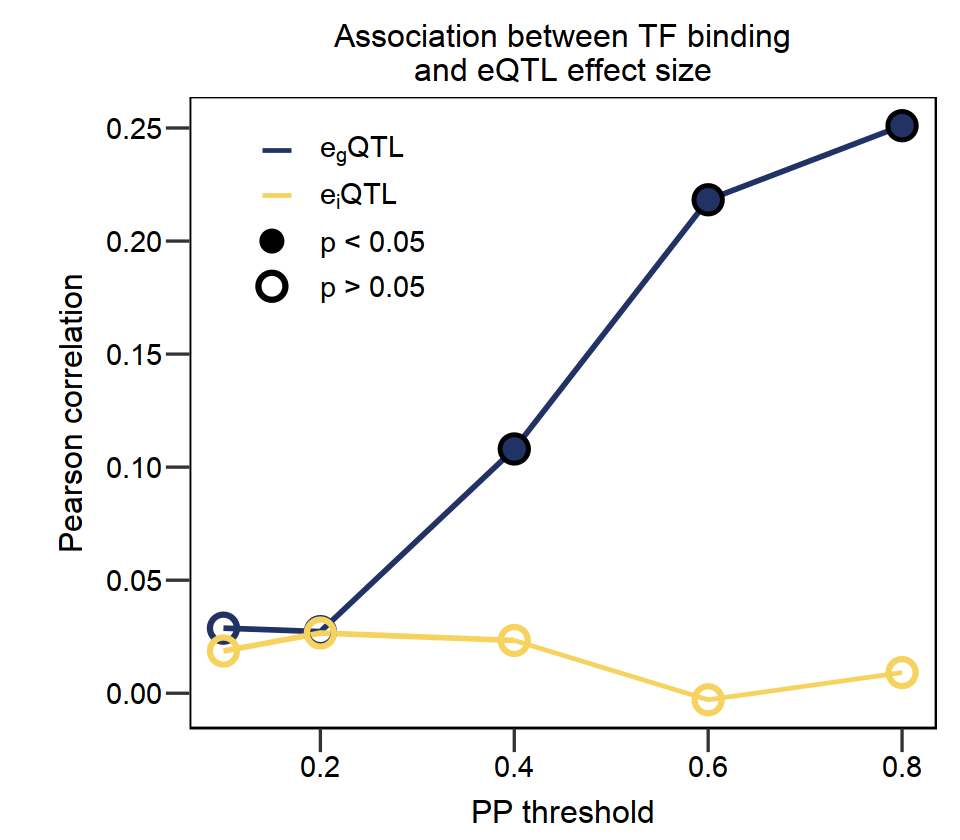

In [50]:
deltasvm = function()
{
#     load("pipeline/17.eQTLFuncEnr/summary/deltaSVM_figure_input.robj", verbose = T)
    load("reviews/tables/Table_SX_DeltaSVM.robj", verbose = T)
    
    gene = datalist[[1]]
    isof = datalist[[2]]

    # 1. Test correlation between deltaSVM score and eQTL beta using linear regression (lm)
    tests = as.data.frame(rbindlist(lapply(c(0.1, 0.2, 0.4, 0.6, 0.8), function(x)
    {
        this_gene = gene %>% filter(SNP.PP > x) %>% group_by(id) %>% filter(abs(deltaSVM_score) == max(abs(deltaSVM_score)))
        this_isof = isof %>% filter(SNP.PP > x) %>% group_by(id) %>% filter(abs(deltaSVM_score) == max(abs(deltaSVM_score)))

        mylm_gene = lm(this_gene$deltaSVM_score ~ this_gene$snp_beta)
        mylm_isof = lm(this_isof$deltaSVM_score ~ this_isof$snp_beta)

        mycor_gene = cor.test(this_gene$deltaSVM_score, this_gene$snp_beta)
        mycor_isof = cor.test(this_isof$deltaSVM_score, this_isof$snp_beta)

        a = data.frame(pp = x, type = "gene", slope = mylm_gene$coefficients[[2]], estimate = mycor_gene$estimate, pval = mycor_gene$p.value)
        b = data.frame(pp = x, type = "isof", slope = mylm_isof$coefficients[[2]], estimate = mycor_isof$estimate, pval = mycor_isof$p.value)

        rbind(a, b)
    })))

    # 2. P-value correction
    tests$qval = p.adjust(tests$pval, "BH")
    tests$is_sig = ifelse(tests$pval <= 0.05, T, F)
    tests$label = paste0("p=", signif(tests$pval, 2))
    print(head(tests))

    # 3. Plot
    psize(w = 8, h = 7)
    p = ggplot(tests) + jn_theme + 
        geom_line(data = tests %>% filter(type == "gene"), aes(x = pp, y = estimate), color = "#213264", size = 1.2) + 
        geom_line(data = tests %>% filter(type == "isof" & pp %in% c(0.1, 0.2, 0.4)), aes(x = pp, y = estimate), color = "#f6d35f", size = 1.2) +
        geom_line(data = tests %>% filter(type == "isof" & !pp %in% c(0.1, 0.2)), aes(x = pp, y = estimate), color = "#f6d35f", size = 1) +
        geom_point(data = tests %>% filter(is_sig == T), aes(x = pp, y = estimate), shape = 1, stroke = 2, size = 6, color = "black") +
        geom_point(data = tests %>% filter(is_sig == T), aes(x = pp, y = estimate, color = type), shape = 16, size = 6) + 
        geom_point(data = tests %>% filter(is_sig == F), aes(x = pp, y = estimate, color = type), size = 6, shape = 1, stroke = 2) +
        ylab("Pearson correlation") + 
        scale_color_manual(values = c("#213264", "#f6d35f"), name = "", labels = c("egQTL", "eiQTL")) +
        theme(
            panel.border = element_rect(size = 0.8),
            legend.position = "none",
            plot.title = element_text(hjust = 0.5, size = 19)
        ) + xlab("PP threshold") 
#         geom_text_repel(data = tests, aes(x = pp, y = estimate, label = label), size = 7)
    
    p = p + annotate("segment", x = 0.14, xend = 0.17, y = 0.24, yend = 0.24, color = "#213264", size = 1) + 
            annotate("segment", x = 0.14, xend = 0.17, y = 0.22, yend = 0.22, color = "#f6d35f", size = 1) + 
            annotate("point", x = 0.15, y = 0.20, color = "black", size = 6) + 
            annotate("point", x = 0.15, y = 0.18, color = "black", size = 6, shape = 1, stroke = 2) + 
            annotate("text", x = 0.2, y = 0.24, label = expression("e"[g]*"QTL"), size = 6, hjust = 0) +
            annotate("text", x = 0.2, y = 0.22, label = expression("e"[i]*"QTL"), size = 6, hjust = 0) +
            annotate("text", x = 0.2, y = 0.20, label = "p < 0.05", size = 6, hjust = 0) +
            annotate("text", x = 0.2, y = 0.18, label = "p > 0.05", size = 6, hjust = 0) +
    ggtitle("Association between TF binding\nand eQTL effect size") +
        theme(plot.title = element_text(hjust = 0.5), 
              axis.ticks = element_line(size = 0.7),
              axis.text = element_text(size = 17),
              axis.title = element_text(size = 19))
        
    
    return(p)
}

deltasvm()

# Figure 1G

  x           class value
1 1       Gene only  3057
2 2       Isof only  1554
3 3   Distinct only    38
4 3 Shared Distinct    39
5 3     Shared only   333
6 3   Indeterminate   598


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'expression'”
Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'expression'”


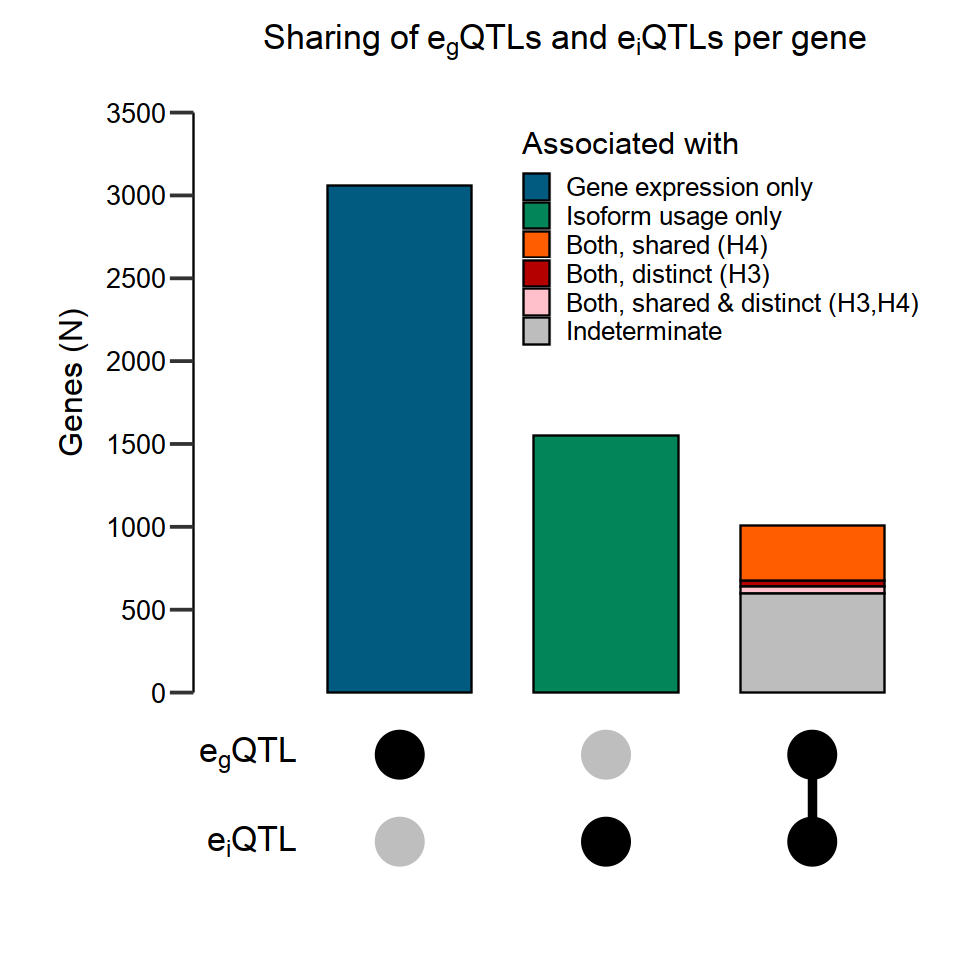

In [66]:
eqtl_class = function()
{
    geneinfo = fread("tables/Table_X_GeneIsoform_Class.txt", data.table = F)
    tobar = list(data.frame(x = 1, class = "Gene only"    , value = length(unique(geneinfo[geneinfo$type == "gene" & geneinfo$class == "eGene only",]$gene_id.short))),
                 data.frame(x = 2, class = "Isof only"    , value = length(unique(geneinfo[geneinfo$type == "gene" & geneinfo$class == "eIsof only",]$gene_id.short))),
                 data.frame(x = 3, class = "Distinct only"  , value = length(unique(geneinfo[geneinfo$type == "gene" & geneinfo$subclass == "Distinct only"  ,]$gene_id.short))),
                 data.frame(x = 3, class = "Shared Distinct", value = length(unique(geneinfo[geneinfo$type == "gene" & geneinfo$subclass == "Shared Distinct",]$gene_id.short))),
                 data.frame(x = 3, class = "Shared only"    , value = length(unique(geneinfo[geneinfo$type == "gene" & geneinfo$subclass == "Shared only"    ,]$gene_id.short))),
                 data.frame(x = 3, class = "Indeterminate"  , value = length(unique(geneinfo[geneinfo$type == "gene" & geneinfo$subclass == "Indeterminate"  ,]$gene_id.short)))
                 )

    tobar = data.frame(rbindlist(tobar)) %>% mutate(x = factor(x, levels = c(1:3)), 
                                                    class = factor(class, levels = c("Gene only", "Isof only", "Shared only", "Distinct only", "Shared Distinct", "Indeterminate")))

    tobar[tobar$class == "Shared only",]$value = 333
    tobar[tobar$class == "Distinct only",]$value = 38
    tobar[tobar$class == "Shared Distinct",]$value = 39
    tobar[tobar$class == "Indeterminate",]$value = 598
    
    print(tobar)

    psize(w = 8, h = 8)
    barp = ggplot(tobar, aes(x = x, y = value, fill = class, label = value)) + 
        geom_bar(stat = "identity", color = "black", width = 0.7) + jn_theme +
#         geom_text(vjust = -0.5) +
        theme(
            panel.border = element_blank(),
            axis.ticks.y = element_line(size = 0.8),
            axis.ticks.x = element_blank(),
            axis.text.x = element_blank(),
            legend.text = element_text(size = 15),
            legend.title = element_text(size = 18),
            axis.text.y = element_text(size = 16),
            axis.title = element_text(size = 19, hjust = 0.5),
            legend.position = c(0.7, 0.8)
        ) + xlab("") + ylim(-1000, 3500) + ylab("                     Genes (N)") + 
        annotate("segment", x = 0, xend = 0, y = 0, yend = 3500, size = 0.5) +
        scale_y_continuous(breaks = c(0, 500, 1000, 1500, 2000, 2500, 3000, 3500)) +
        scale_fill_manual(values = c("#015b80", "#028559", "#ff5d00",  "#b50000", "pink", "#bdbdbd"), name = "Associated with", 
                          label = c("Gene expression only", "Isoform usage only", "Both, shared (H4)", 
                                     "Both, distinct (H3)", "Both, shared & distinct (H3,H4)", "Indeterminate")) +
        annotate("point", x = c(2,1,3,3), y = c(-900,-375,-375,-900), size = 13, color = "black") +
        annotate("point", x = c(2,1), y = c(-375,-900), size = 13, color = "grey") +
        annotate("segment", x = 3, xend = 3, y = -375, yend = -900, color = "black", size = 2) +
        annotate("text", x = 0.5, y = -375, label = expression("e"[g]*"QTL"), size = 7, hjust = 1) +
        annotate("text", x = 0.5, y = -900, label = expression("e"[i]*"QTL"), size = 7, hjust = 1) +
        coord_cartesian(clip = "off") +
        ggtitle(expression("Sharing of e"[g]*"QTLs and e"[i]*"QTLs per gene")) + theme(plot.title = element_text(hjust = 0.5, size = 20))

    return(barp)
}

suppressWarnings(eqtl_class())

In [11]:
g1 = suppressWarnings(suppressMessages(plot_grid(NULL, labels = c("a"), label_size = 33)))
g2 = suppressWarnings(suppressMessages(plot_grid(plot_pdx1(), plot_egene(), plot_eisoform(), nrow = 1, labels = c("b", "c", "d"), label_size = 33, rel_widths = c(0.8, 0.7, 0.55))))
g3 = suppressWarnings(suppressMessages(plot_grid( genomic_enr(), deltasvm(), eqtl_class(), nrow = 1, labels = c("e", "f", "g"), label_size = 33, rel_widths = c(0.8, 0.8, 0.8))))

png("reviews/figures/figure1.png", width = 9000, height = 8500, res = 400)
plot_grid(g1, g2, NULL, g3, ncol = 1, rel_heights = c(0.9, 1, 0.06, 1))
dev.off()

Loading objects:
  datalist
   pp type      slope   estimate      pval      qval is_sig  label
1 0.1 gene 0.20445131 0.03004474 0.1153430 0.2883574  FALSE p=0.12
2 0.1 isof 0.09607196 0.01822535 0.3219827 0.5772477  FALSE p=0.32
3 0.2 gene 0.17334731 0.02702109 0.3847073 0.5772477  FALSE p=0.38
4 0.2 isof 0.13899962 0.02694529 0.4040734 0.5772477  FALSE  p=0.4
5 0.4 gene 0.59681807 0.10804066 0.0402025 0.1340083   TRUE p=0.04
6 0.4 isof 0.12176705 0.02421652 0.6451573 0.8064466  FALSE p=0.65
  x           class value
1 1       Gene only  3057
2 2       Isof only  1554
3 3   Distinct only    38
4 3 Shared Distinct    39
5 3     Shared only   333
6 3   Indeterminate   598


png 
  2